# Monte Carlo Dispersion Analysis

## Initialization Cells

In [1]:
from rocketpy import *
from numpy.random import normal, uniform, choice
from datetime import datetime
import glob

In [2]:
%matplotlib notebook

In [11]:
%matplotlib inline

## Defining Analysis Parameters

In [3]:
analysis_parameters = {"impulse": (1240, 100),                  # Propulsion Details
                       "burnOut": (2.84, 0.15),
                  "nozzleRadius": (30/1000, 0.5/1000),
                  "throatRadius": (8/1000, 0.5/1000),
               "grainSeparation": (1/1000, 0.5/1000),
                  "grainDensity": (1707, 24),
              "grainOuterRadius": (21.05/1000, 0.137/1000),
       "grainInitialInnerRadius": (9.63/1000, 0.076/1000),
            "grainInitialHeight": (118.38/1000, 0.415/1000),
                        "m_prop": (1.664, 0.05),
                        "m_aero": (0.696, 0.02),                # Aerodynamic Details
                      "inertiaI": (0.3437,0.01*0.3437),
                      "inertiaZ": (0.00288,0.01*0.00288),
                        "radius": (0.0378,0.0001),
          "distanceRocketNozzle": (-0.467,0.003),
      "distanceRocketPropellant": (-0.091,0.003),
                  "powerOffDrag": (1,0.03),
                   "powerOnDrag": (1,0.03),
                    "noseLength": (0.151, 0.001),
              "noseDistanceToCM": (0.539, 0.003),
              "tailBottomRadius": (0.0602/2, 0.0001),
                    "tailLength": (0.00765, 0.0001),
              "tailDistanceToCM": (0.168, 0.003),
                       "finSpan": (0.070, 0.001),
                  "finRootChord": (0.08, 0.001),
                   "finTipChord": (0.04, 0.001),
               "finDistanceToCM": (-0.344, 0.003),
                   "inclination": (85, 1),                       # Launch and Environment Details
                       "heading": (90, 1),
                    "railLength": (2.2, 0.01),
                          "time": [0, 6, 12, 18],
                           "day": [1, 2, 3, 4, 5, 6, 7, 8],
                          "year": [2017],
                         "m_rec": (0.160, 0.024),                # Parachute Details
                           "CdS": (0.43, 0.086),
                       "lag_rec": (1 , 0.5),
                          "m_se": (0.300, 0.02),                 # Electronic Systems Details
                        "lag_se": (0.73, 0.16)}

## Creating a Flight Settings Generator

In [4]:
def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] =  normal(*parameter_value)
            else:
                flight_setting[parameter_key] =  choice(parameter_value)
        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

## Importing Parachute Trigger Function

In [5]:
def drogueTrigger(p, y):
    return False # Simulate ballistc flight

## Creating a Export Function

In [6]:
# Generate a random filename
filename = 'Dispersion Sample'

dispersion_input_file = open(str(filename)+'.disp_input', 'w+')
dispersion_output_file = open(str(filename)+'.disp_output', 'w+')

def export_flight_data(flight_setting, flight_data):
    # Generate flight results
    flight_result = {"outOfRailTime": flight_data.outOfRailTime,
                 "outOfRailVelocity": flight_data.outOfRailVelocity,
                        "apogeeTime": flight_data.apogeeTime,
                    "apogeeAltitude": flight_data.apogee,
                           "apogeeX": flight_data.apogeeX,
                           "apogeeY": flight_data.apogeeY,
                        "impactTime": flight_data.tFinal,
                           "impactX": flight_data.xImpact,
                           "impactY": flight_data.yImpact,
                    "impactVelocity": flight_data.impactVelocity,
               "initialStaticMargin": flight_data.rocket.staticMargin(0),
             "outOfRailStaticMargin": flight_data.rocket.staticMargin(TestFlight.outOfRailTime),
                 "finalStaticMargin": flight_data.rocket.staticMargin(TestFlight.rocket.motor.burnOutTime),
                    "numberOfEvents": len(flight_data.parachuteEvents)}
    
    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(sol[:, [0, 4]], 'Time (s)', 'Vx (m/s)', 'linear', extrapolation="natural")
    flight_data.vy = Function(sol[:, [0, 5]], 'Time (s)', 'Vy (m/s)', 'linear', extrapolation="natural")
    flight_data.vz = Function(sol[:, [0, 6]], 'Time (s)', 'Vz (m/s)', 'linear', extrapolation="natural")
    flight_data.v = (flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2)**0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result['maxVelocity'] = flight_data.maxVel
    
    # Take care of parachute results
    if len(flight_data.parachuteEvents) > 0:
        flight_result['drogueTriggerTime'] = flight_data.parachuteEvents[0][0]
        flight_result['drogueInflatedTime'] = flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        flight_result['drogueInflatedVelocity'] = flight_data.v(flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag)
    else:
        flight_result['drogueTriggerTime'] = 0
        flight_result['drogueInflatedTime'] = 0
        flight_result['drogueInflatedVelocity'] = 0
    
    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + '\n')
    dispersion_output_file.write(str(flight_result) + '\n')    

## Simulating Each Flight Setting

In [7]:
# Initialize counter and timer
i = 0
initial_time = datetime.now()

# Iterate over flight settings
for setting in flight_settings(analysis_parameters, 20):
    # Print current iteration
    i += 1
    if i != 1:
        print("Curent iteration: ", i, " | Average Time per Iteration: {:2.6f} s".format((datetime.now() - initial_time).seconds/(i-1)), end='\r')
    
    # Create environment
    Env = Environment(railLength=setting['railLength'],
                      latitude=-21.960607,
                      longitude=-47.481946,
                      elevation=627)
    Env.setDate((setting['year'], 2, setting['day'], setting['time']))
    Env.setAtmosphericModel(type='Reanalysis', file='data/weather/CuritibaRioSaoPaulo_2017_ERA-5.nc', dictionary='ECMWF')
    
    
    # Create motor
    Jiboia56 = SolidMotor(thrustSource='data/mandioca/thrustCurve.csv',
                      burnOut=5.78,
                      reshapeThrustCurve=(setting['burnOut'], setting['impulse']),
                      nozzleRadius=setting['nozzleRadius'],
                      throatRadius=setting['throatRadius'],
                      grainNumber=6,
                      grainSeparation=setting['grainSeparation'],
                      grainDensity=setting['grainDensity'],
                      grainOuterRadius=setting['grainOuterRadius'],
                      grainInitialInnerRadius=setting['grainInitialInnerRadius'],
                      grainInitialHeight=setting['grainInitialHeight'])
    
    # Create rocket
    EuporiaIII = Rocket(motor=Jiboia56,
                        radius=setting['radius'],
                        mass=setting['m_aero'] + setting['m_se'] + setting['m_aero'] + setting['m_prop'],
                        inertiaI=setting['inertiaI'],
                        inertiaZ=setting['inertiaZ'],
                        distanceRocketNozzle=setting['distanceRocketNozzle'],
                        distanceRocketPropellant=setting['distanceRocketPropellant'],
                        powerOffDrag='data/euporia/euporiaIIIdrag.csv',
                        powerOnDrag='data/euporia/euporiaIIIdrag.csv')
    
    # Edit rocket drag
    EuporiaIII.powerOffDrag *= setting["powerOffDrag"]
    EuporiaIII.powerOnDrag *= setting["powerOnDrag"]
    
    # Add rocket nose, fins and tail
    NoseCone = EuporiaIII.addNose(length=setting['noseLength'], kind='vonKarman', distanceToCM=setting['noseDistanceToCM'])
    FinSet = EuporiaIII.addFins(n=4, rootChord=setting['finRootChord'], tipChord=setting['finTipChord'], span=setting['finSpan'], distanceToCM=setting['finDistanceToCM'])
    Tail = EuporiaIII.addTail(topRadius=setting['radius'], bottomRadius=setting['tailBottomRadius'], length=setting['tailLength'], distanceToCM=setting['tailDistanceToCM'])
    
    # Add parachute
    Drogue = EuporiaIII.addParachute('Drogue',
                                     CdS=setting['CdS'],
                                     trigger=drogueTrigger, 
                                     samplingRate=105,
                                     lag=setting['lag_rec'] + setting['lag_se'],
                                     noise=(0, 8.3, 0.5))
    EuporiaIII.setRailButtons([0.2, -0.5])
    # Simulate flight
    try:
        TestFlight = Flight(rocket=EuporiaIII, environment=Env, inclination=setting['inclination'], heading=setting['heading'])

        # Export flight results
        export_flight_data(setting, TestFlight)
    except IndexError:
        dispersion_error_file = open(str(filename)+'.disp_error', 'w+')
        dispersion_error_file.write(str(setting) + '\n')
        dispersion_error_file.close()

Curent iteration:  2  | Average Time per Iteration: 2.000000 sCurent iteration:  3  | Average Time per Iteration: 1.500000 sCurent iteration:  4  | Average Time per Iteration: 1.666667 sCurent iteration:  5  | Average Time per Iteration: 1.500000 sCurent iteration:  6  | Average Time per Iteration: 1.600000 sCurent iteration:  7  | Average Time per Iteration: 1.500000 sCurent iteration:  8  | Average Time per Iteration: 1.571429 sCurent iteration:  9  | Average Time per Iteration: 1.500000 sCurent iteration:  10  | Average Time per Iteration: 1.444444 sCurent iteration:  11  | Average Time per Iteration: 1.500000 sCurent iteration:  12  | Average Time per Iteration: 1.545455 sCurent iteration:  13  | Average Time per Iteration: 1.500000 sCurent iteration:  14  | Average Time per Iteration: 1.461538 sCurent iteration:  15  | Average Time per Iteration: 1.500000 sCurent iteration:  16  | Average Time per Iteration: 1.466667 sCurent iteration:  17  | Average Time per Iteration: 1.500000 s

## Closing Input and Output Files

In [8]:
dispersion_input_file.close()
dispersion_output_file.close()

## Importing Dispersion Analysis Saved Data

In [9]:
# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {"outOfRailTime": [],
                  "outOfRailVelocity": [],
                         "apogeeTime": [],
                     "apogeeAltitude": [],
                            "apogeeX": [],
                            "apogeeY": [],
                         "impactTime": [],
                            "impactX": [],
                            "impactY": [],
                     "impactVelocity": [],
                "initialStaticMargin": [],
              "outOfRailStaticMargin": [],
                  "finalStaticMargin": [],
                     "numberOfEvents": [],
                        "maxVelocity": [],
                    "drogueTriggerTime": [],
                   "drogueInflatedTime": [],
               "drogueInflatedVelocity": []}

# Get all dispersion results
for filename in glob.iglob('*.disp_output'):
    # Get file
    dispersion_output_file = open(filename, 'r')
    
    # Read each line of the file and convert to dict
    for line in dispersion_output_file:
        flight_result = eval(line)

        # Store general result
        dispersion_general_results.append(flight_result)

        # Store result by type
        for parameter_key, parameter_value in flight_result.items():
            dispersion_results[parameter_key].append(parameter_value)

    # Close data file
    dispersion_output_file.close()

# Print number of flights simulated
print('Number of simulations: ', len(dispersion_general_results))

Number of simulations:  20


## Dispersion Results

### Out of Rail Time

Out of Rail Time - Mean Value:  0.387936197158227
Out of Rail Time - Standard Deviation:  0.020369951646318052


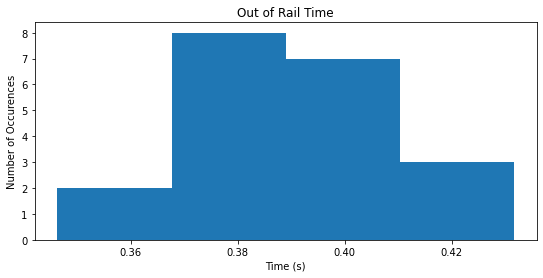

In [12]:
print('Out of Rail Time - Mean Value: ', np.mean(dispersion_results["outOfRailTime"]))
print('Out of Rail Time - Standard Deviation: ', np.std(dispersion_results["outOfRailTime"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["outOfRailTime"], 'scott')
plt.title('Out of Rail Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Out of Rail Velocity

Out of Rail Velocity - Mean Value:  14.4150403458223
Out of Rail Velocity - Standard Deviation:  0.6857573027371834


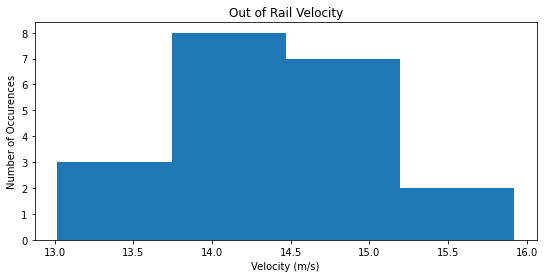

In [13]:
print('Out of Rail Velocity - Mean Value: ', np.mean(dispersion_results["outOfRailVelocity"]))
print('Out of Rail Velocity - Standard Deviation: ', np.std(dispersion_results["outOfRailVelocity"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["outOfRailVelocity"], 'scott')
plt.title('Out of Rail Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Apoge Time

Apogee Time - Mean Value:  18.849011353853598
Apogee Time - Standard Deviation:  0.517984387071162


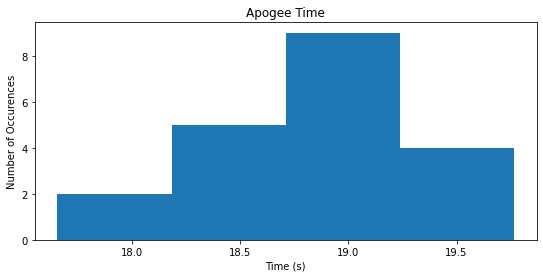

In [14]:
print('Apogee Time - Mean Value: ', np.mean(dispersion_results["apogeeTime"]))
print('Apogee Time - Standard Deviation: ', np.std(dispersion_results["apogeeTime"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["apogeeTime"], 'scott')
plt.title('Apogee Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee Altitude

Apogee Altitude - Mean Value:  2564.654862480653
Apogee Altitude - Standard Deviation:  143.41368877497635


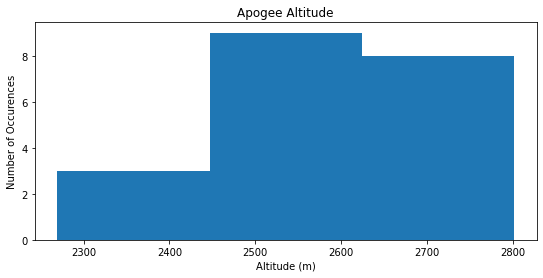

In [15]:
print('Apogee Altitude - Mean Value: ', np.mean(dispersion_results["apogeeAltitude"]))
print('Apogee Altitude - Standard Deviation: ', np.std(dispersion_results["apogeeAltitude"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["apogeeAltitude"], 'scott')
plt.title('Apogee Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee X Position

Apogee X Position - Mean Value:  324.16381564326946
Apogee X Position - Standard Deviation:  92.8930401472697


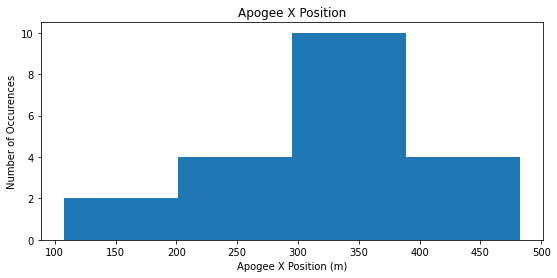

In [16]:
print('Apogee X Position - Mean Value: ', np.mean(dispersion_results["apogeeX"]))
print('Apogee X Position - Standard Deviation: ', np.std(dispersion_results["apogeeX"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["apogeeX"], 'scott')
plt.title('Apogee X Position')
plt.xlabel('Apogee X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee Y Position

Apogee Y Position - Mean Value:  22.553632266294954
Apogee Y Position - Standard Deviation:  100.64598634672339


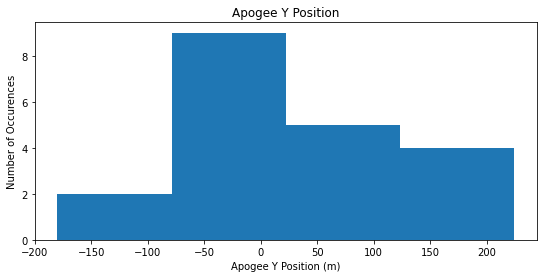

In [17]:
print('Apogee Y Position - Mean Value: ', np.mean(dispersion_results["apogeeY"]))
print('Apogee Y Position - Standard Deviation: ', np.std(dispersion_results["apogeeY"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["apogeeY"], 'scott')
plt.title('Apogee Y Position')
plt.xlabel('Apogee Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Time

Impact Time - Mean Value:  41.39447451872618
Impact Time - Standard Deviation:  1.4534350580118944


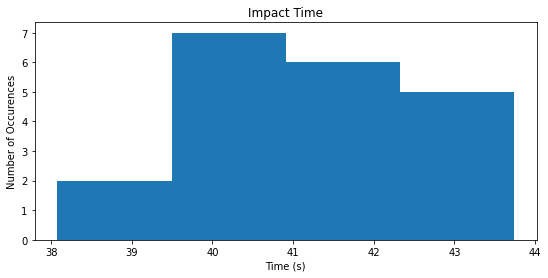

In [18]:
print('Impact Time - Mean Value: ', np.mean(dispersion_results["impactTime"]))
print('Impact Time - Standard Deviation: ', np.std(dispersion_results["impactTime"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["impactTime"], 'scott')
plt.title('Impact Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact X Position

Impact X Position - Mean Value:  574.9432606652096
Impact X Position - Standard Deviation:  155.25820546728903


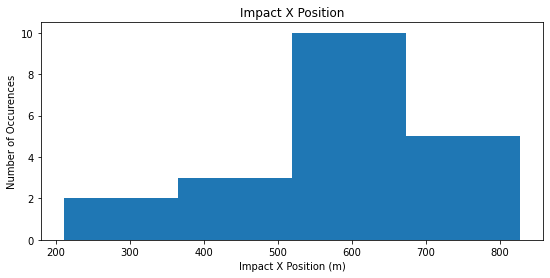

In [19]:
print('Impact X Position - Mean Value: ', np.mean(dispersion_results["impactX"]))
print('Impact X Position - Standard Deviation: ', np.std(dispersion_results["impactX"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["impactX"], 'scott')
plt.title('Impact X Position')
plt.xlabel('Impact X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Y Position

Impact Y Position - Mean Value:  23.54915835124111
Impact Y Position - Standard Deviation:  173.70556415338945


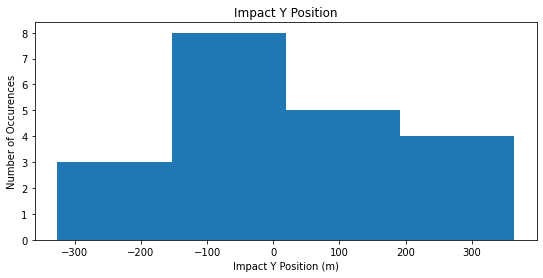

In [20]:
print('Impact Y Position - Mean Value: ', np.mean(dispersion_results["impactY"]))
print('Impact Y Position - Standard Deviation: ', np.std(dispersion_results["impactY"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["impactY"], 'scott')
plt.title('Impact Y Position')
plt.xlabel('Impact Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Velocity

Impact Velocity- Mean Value:  -137.3969149723876
Impact Velocity - Standard Deviation:  2.923527659257795


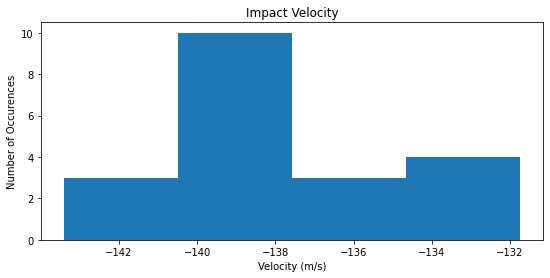

In [21]:
print('Impact Velocity- Mean Value: ', np.mean(dispersion_results["impactVelocity"]))
print('Impact Velocity - Standard Deviation: ', np.std(dispersion_results["impactVelocity"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["impactVelocity"], 'scott')
plt.title('Impact Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Static Margin

Initial Static Margin - Mean Value:  2.178908266663036
Initial Static Margin - Standard Deviation:  0.06405021730804486
Out of Rail Static Margin - Mean Value:  2.195536410962686
Out of Rail Static Margin - Standard Deviation:  0.06357589088478798
Final Static Margin - Mean Value:  2.5210321259706077
Final Static Margin - Standard Deviation:  0.05935938585824946


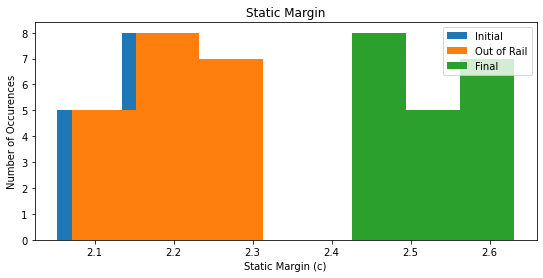

In [22]:
print('Initial Static Margin - Mean Value: ', np.mean(dispersion_results["initialStaticMargin"]))
print('Initial Static Margin - Standard Deviation: ', np.std(dispersion_results["initialStaticMargin"]))
print('Out of Rail Static Margin - Mean Value: ', np.mean(dispersion_results["outOfRailStaticMargin"]))
print('Out of Rail Static Margin - Standard Deviation: ', np.std(dispersion_results["outOfRailStaticMargin"]))
print('Final Static Margin - Mean Value: ', np.mean(dispersion_results["finalStaticMargin"]))
print('Final Static Margin - Standard Deviation: ', np.std(dispersion_results["finalStaticMargin"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["initialStaticMargin"], label='Initial', bins='scott')
plt.hist(dispersion_results["outOfRailStaticMargin"], label='Out of Rail', bins='scott')
plt.hist(dispersion_results["finalStaticMargin"], label='Final', bins='scott')
plt.legend()
plt.title('Static Margin')
plt.xlabel('Static Margin (c)')
plt.ylabel('Number of Occurences')
plt.show()

### Maximum Velocity

Maximum Velocity- Mean Value:  256.85632716933054
Maximum Velocity - Standard Deviation:  18.218277655334337


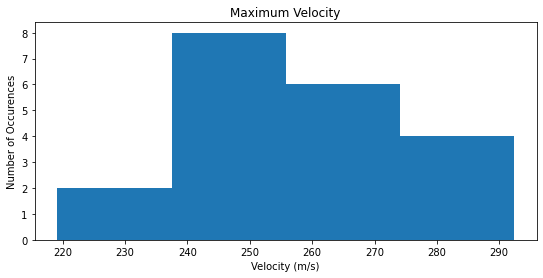

In [23]:
print('Maximum Velocity- Mean Value: ', np.mean(dispersion_results["maxVelocity"]))
print('Maximum Velocity - Standard Deviation: ', np.std(dispersion_results["maxVelocity"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["maxVelocity"], 'scott')
plt.title('Maximum Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Parachute Events

Parachute Events - Mean Value:  0.0
Parachute Events - Standard Deviation:  0.0


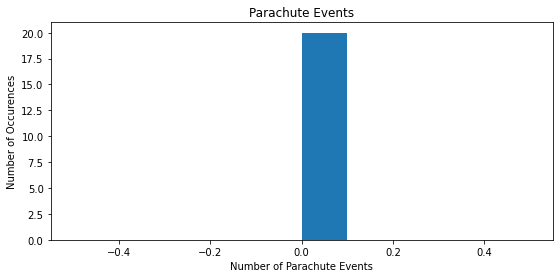

In [24]:
print('Parachute Events - Mean Value: ', np.mean(dispersion_results["numberOfEvents"]))
print('Parachute Events - Standard Deviation: ', np.std(dispersion_results["numberOfEvents"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["numberOfEvents"])
plt.title('Parachute Events')
plt.xlabel('Number of Parachute Events')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Trigger Time

Drogue Parachute Trigger Time - Mean Value:  0.0
Drogue Parachute Trigger Time - Standard Deviation:  0.0


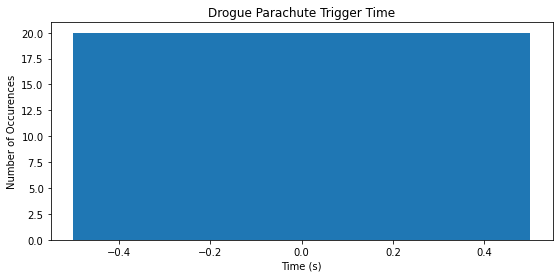

In [25]:
print('Drogue Parachute Trigger Time - Mean Value: ', np.mean(dispersion_results["drogueTriggerTime"]))
print('Drogue Parachute Trigger Time - Standard Deviation: ', np.std(dispersion_results["drogueTriggerTime"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["drogueTriggerTime"], 'scott')
plt.title('Drogue Parachute Trigger Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Fully Inflated Time

Drogue Parachute Fully Inflated Time - Mean Value:  0.0
Drogue Parachute Fully Inflated Time - Standard Deviation:  0.0


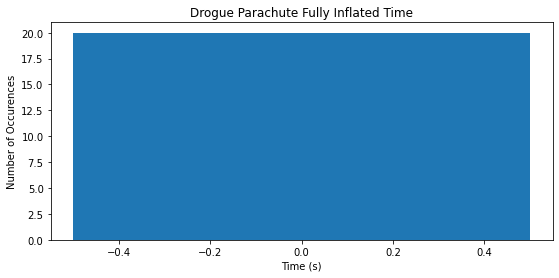

In [26]:
print('Drogue Parachute Fully Inflated Time - Mean Value: ', np.mean(dispersion_results["drogueInflatedTime"]))
print('Drogue Parachute Fully Inflated Time - Standard Deviation: ', np.std(dispersion_results["drogueInflatedTime"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["drogueInflatedTime"], 'scott')
plt.title('Drogue Parachute Fully Inflated Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Fully Inflated Velocity

Drogue Parachute Fully Inflated Velocity - Mean Value:  0.0
Drogue Parachute Fully Inflated Velocity - Standard Deviation:  0.0


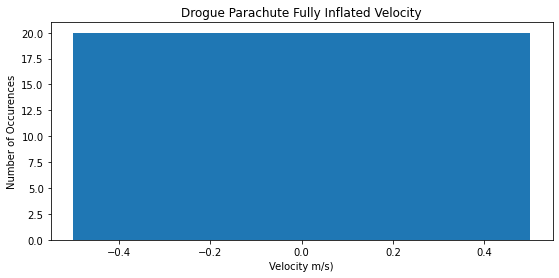

In [27]:
print('Drogue Parachute Fully Inflated Velocity - Mean Value: ', np.mean(dispersion_results["drogueInflatedVelocity"]))
print('Drogue Parachute Fully Inflated Velocity - Standard Deviation: ', np.std(dispersion_results["drogueInflatedVelocity"]))
plt.figure(figsize=(9,4))
plt.hist(dispersion_results["drogueInflatedVelocity"], 'scott')
plt.title('Drogue Parachute Fully Inflated Velocity')
plt.xlabel('Velocity m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Mean and Standard Deviation Variation with Number of Simulations

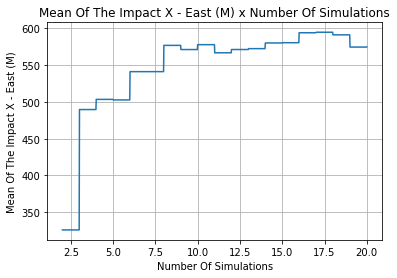

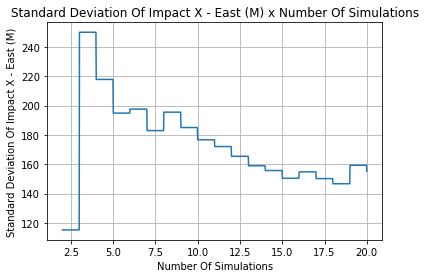

In [28]:
mean = Function(lambda x: np.mean(dispersion_results["impactX"][0:int(x)]))
mean.setInputs('Number of Simulations')
mean.setOutputs('Mean of the Impact X - East (m)')
mean.plot(2, len(dispersion_results["impactX"]))

std = Function(lambda x: np.std(dispersion_results["impactX"][0:int(x)]))
std.setInputs('Number of Simulations')
std.setOutputs('Standard Deviation of Impact X - East (m)')
std.plot(2, len(dispersion_results["impactX"]))

### Error Ellipses

In [29]:
!pip install imageio

In [51]:
!pip install plotly
!pip install "notebook>=5.3" "ipywidgets>=7.2"
!pip install folium

  Using cached folium-0.11.0-py2.py3-none-any.whl (93 kB)
  Using cached branca-0.4.1-py3-none-any.whl (24 kB)


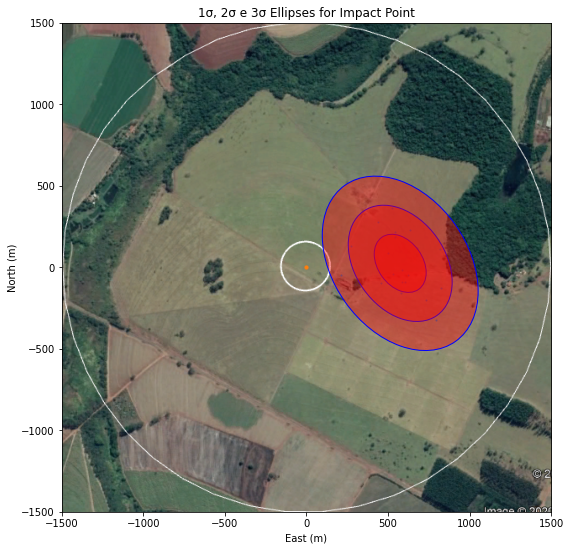

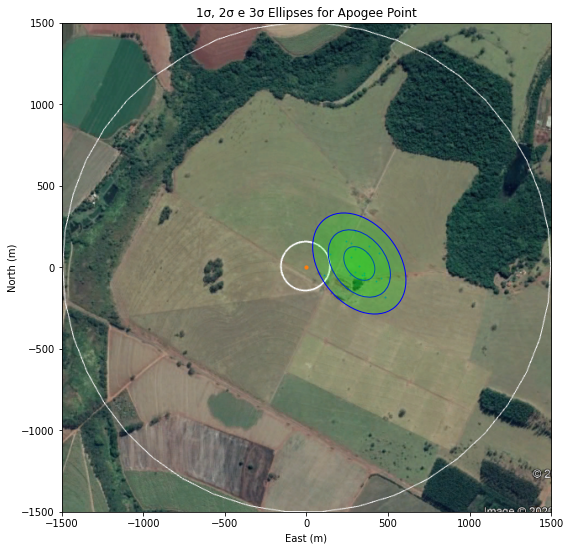

In [52]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse
import plotly
import folium

# Import background map
img = imread("Temisto_LaunchPad_1000R.png")

# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results['apogeeX'])
apogeeY = np.array(dispersion_results['apogeeY'])
impactX = np.array(dispersion_results['impactX'])
impactY = np.array(dispersion_results['impactY'])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]
  
# Create plot figure
plt.figure(num=None, figsize=(9, 9), facecolor='w', edgecolor='k')
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:,0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
for j in [1, 2, 3]:
    impactEll = Ellipse(xy=(np.mean(impactX), np.mean(impactY)),
                  width=impactW*j, height=impactH*j,
                  angle=impactTheta, color='blue')
    impactEll.set_facecolor((1, 0, 0, 0.4))
    ax.add_artist(impactEll)

# Draw impact points
plt.scatter(impactX, impactY, s=1)
import plotly.express as px
fig = px.scatter(x=impactX, y=impactY)
fig.update_layout(title= "Pontos de Impacto")
fig.show()

# Draw launch point
plt.scatter(0, 0, s=10)

# Add title and labels to plot
ax.set_title('1σ, 2σ e 3σ Ellipses for Impact Point')
ax.set_ylabel('North (m)')
ax.set_xlabel('East (m)')

# Add background image to plot
dx = 0
dy = 0
plt.imshow(img,zorder=0, extent=[-1500-dx, 1500-dx, -1500-dy, 1500-dy])
    
plt.figure(num=None, figsize=(9, 9), facecolor='w', edgecolor='k')
ax = plt.subplot(111)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:,0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(xy=(np.mean(apogeeX), np.mean(apogeeY)),
                  width=apogeeW*j, height=apogeeH*j,
                  angle=apogeeTheta, color='blue')
    apogeeEll.set_facecolor((0, 1, 0, 0.2))
    ax.add_artist(apogeeEll)



    

# Draw apogee points
plt.scatter(apogeeX, apogeeY, s=1)
fig2 = px.scatter(x=apogeeX, y=apogeeY)
fig2.update_layout(title= "Pontos de Apogeu")
fig2.show()

# Draw launch point
plt.scatter(0, 0, s=10)

# Add title and labels to plot
ax.set_title('1σ, 2σ e 3σ Ellipses for Apogee Point')
ax.set_ylabel('North (m)')
ax.set_xlabel('East (m)')

# Add background image to plot
dx = 0
dy = 0
plt.imshow(img,zorder=0, extent=[-1500-dx, 1500-dx, -1500-dy, 1500-dy])

plt.show()